# Install requirements and import initial libraries

In [1]:
!pip install -r requirements.txt

import pandas as pd
import numpy as np

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 41.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 45.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 68.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 13.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 29.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 12.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━

# Load combined dataset

In [2]:
from datasets import load_dataset

# Load the data
dataset = load_dataset("TLeonidas/twitter-hate-speech-en-240ksamples")

# Transform into a pandas DataFrame
df = dataset["train"].to_pandas()

Generating train split: 0 examples [00:00, ? examples/s]

# Visualize labels distribution

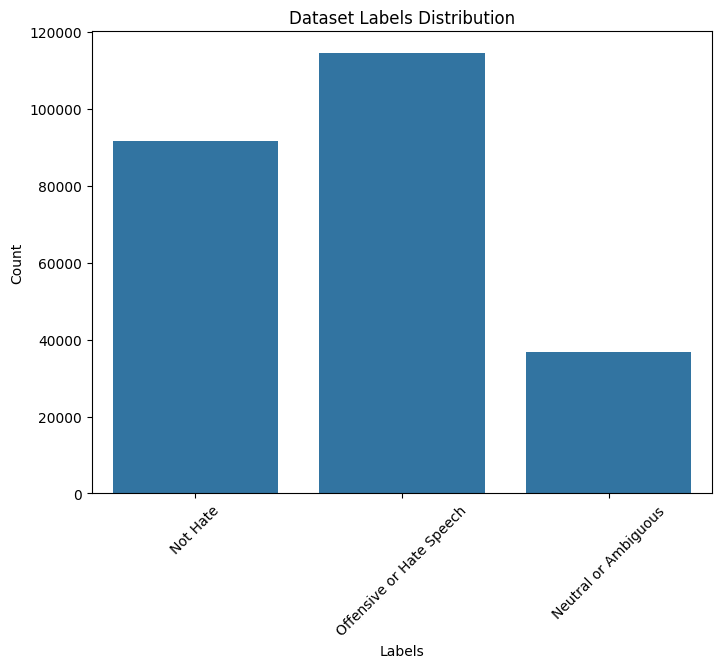

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

label_order_reversed = df['labels'].unique()[::-1]

plt.figure(figsize=(8, 6))
sns.countplot(data=df, x='labels', order=label_order_reversed)
plt.title('Dataset Labels Distribution')
plt.xlabel('Labels')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

# Introduce leet language dictionary

In [4]:
leet_dict = {
    '0': 'o',
    '1': 'i',
    '3': 'e',
    '4': 'a',
    '5': 's',
    '7': 't',
    '@': 'a',
    '$': 's',
    '9': 'g',
}

def translate_leet(text):
    translated = ''.join([leet_dict.get(char, char) for char in text])
    return translated

# Preprocess the data

In [5]:
import re
import string
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer

stopword = set(stopwords.words('english'))
# Remove 'not' from the stopwords list as we want to keep it
stopword.remove('not')

def clean(text):
    text = str(text)
    # Preserve "Not" by temporarily replacing it
    text = re.sub(r'\bNot\b', 'temporarynotplaceholder', text)

    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)

    # Modify punctuation removal to preserve "@"
    text = re.sub('[%s]' % re.escape(string.punctuation.replace('@', '')), '', text)
    text = re.sub('\n', '', text)

    # Preserving leet speak by not removing words with numbers
    text = " ".join([word for word in text.split() if word not in stopword])

    # Restore "Not" in its proper case
    text = re.sub('temporarynotplaceholder', 'Not', text)

    return text

# Function to process text through the pipeline
def process_text(text):
    # Translate leet speak
    text = translate_leet(text)

    # Clean the text
    text = clean(text)

    return text

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [6]:
# Apply the leet language and clean the data
df['tweet'] = df['tweet'].apply(process_text)

# Transform columns to numpy arrays
x = np.array(df["tweet"])
y = np.array(df["labels"])

# Import label encoder

In [7]:
from joblib import load

# Import the LabelEncoder
label_encoder = load('label_encoder.joblib')

# Fit label encoder and return encoded labels
y_encoded = label_encoder.fit_transform(y)

In [ ]:
# Code used to initially enconde the labels. Not needed since we've imported it
'''
from sklearn.preprocessing import LabelEncoder

# Initialize the LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder and return encoded labels
y_encoded = label_encoder.fit_transform(y)
'''

# Split data and import vectorizer

In [8]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(x, y_encoded, test_size = 0.25, random_state = 42)


In [9]:
# Import vectorizer

cv = load('count_vectorizer.joblib')
X_train_vectorized = cv.fit_transform(X_train)
X_test_vectorized = cv.transform(X_test)

In [ ]:
# Code used to initially vectorize the 'tweets'. Not needed since we've imported it
'''
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer()
# Fit CountVectorizer on the training data and transform the training data
X_train_vectorized = cv.fit_transform(X_train)

# Transform the test data with the same vectorizer
X_test_vectorized = cv.transform(X_test)
'''

# Import the models

In [10]:
from joblib import load

# Load the model from the file
clf_decision_tree = load('/content/clf_cv_3labels.joblib')

!pip install huggingface_hub
from huggingface_hub import hf_hub_download

model_file_path = hf_hub_download(repo_id="TLeonidas/clf-random-forest", filename="random_forest_model_3labels.joblib")

clf_random_forest = load(model_file_path)

random_forest_model_3labels.joblib:   0%|          | 0.00/924M [00:00<?, ?B/s]

In [ ]:
# Code used to train the classifiers. Not needed since we've imported them
'''
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# Decision Tree Classifier
clf_decision_tree = DecisionTreeClassifier()
clf_decision_tree.fit(X_train_vectorized, y_train)

# Random Forest Classifier
clf_random_forest = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
clf_random_forest.fit(X_train_vectorized, y_train)'''

# Evaluate the models performance

In [11]:
from sklearn.metrics import accuracy_score, classification_report

# Predict on the test data
y_pred_decision_tree = clf_decision_tree.predict(X_test_vectorized)
y_pred_random_forest = clf_random_forest.predict(X_test_vectorized)

# Inverse transform to get original labels (unencoded)
y_test_original = label_encoder.inverse_transform(y_test)
y_pred_decision_tree_original = label_encoder.inverse_transform(y_pred_decision_tree)
y_pred_random_forest_original = label_encoder.inverse_transform(y_pred_random_forest)

# Evaluate the models with original string labels
print("Decision Tree Classifier Accuracy:", accuracy_score(y_test_original, y_pred_decision_tree_original))
print("Random Forest Classifier Accuracy:", accuracy_score(y_test_original, y_pred_random_forest_original))

# Detailed performance report with original string labels
print("\nDecision Tree Classifier Report:\n", classification_report(y_test_original, y_pred_decision_tree_original))
print("\nRandom Forest Classifier Report:\n", classification_report(y_test_original, y_pred_random_forest_original))

Decision Tree Classifier Accuracy: 0.9035181675867183
Random Forest Classifier Accuracy: 0.9006509021998846

Decision Tree Classifier Report:
                           precision    recall  f1-score   support

    Neutral or Ambiguous       0.86      0.85      0.86      9194
                Not Hate       0.89      0.92      0.91     22951
Offensive or Hate Speech       0.92      0.91      0.92     28540

                accuracy                           0.90     60685
               macro avg       0.89      0.89      0.89     60685
            weighted avg       0.90      0.90      0.90     60685


Random Forest Classifier Report:
                           precision    recall  f1-score   support

    Neutral or Ambiguous       0.93      0.82      0.87      9194
                Not Hate       0.88      0.92      0.90     22951
Offensive or Hate Speech       0.91      0.91      0.91     28540

                accuracy                           0.90     60685
               macro avg 

# Transform predictions to probabilities

In [12]:
# Ensure Decision Tree and Random Forest predictions are probabilities
y_pred_dt_proba = clf_decision_tree.predict_proba(X_test_vectorized)
y_pred_rf_proba = clf_random_forest.predict_proba(X_test_vectorized)

# Average the probabilities across the three models
# Note: You need to ensure the predictions are aligned and in the same order!
avg_pred_proba = (y_pred_dt_proba + y_pred_rf_proba) / 2

# Choose the class with the highest average probability
y_pred_ensemble = np.argmax(avg_pred_proba, axis=1)

# Ensemble and evaluate predictions (Average)

In [13]:
def ensemble_predictions(models, input_features):
    # Assuming each model has a .predict_proba() method that returns probabilities for each class
    predictions = [model.predict_proba(input_features) for model in models]
    # Average the probabilities across all models
    avg_predictions = np.mean(predictions, axis=0)
    return avg_predictions

# Ensemble the models and get predictions
ensemble_pred = ensemble_predictions([clf_decision_tree, clf_random_forest], X_test_vectorized)

In [14]:
# Convert averaged probabilities to class labels (encoded)
y_pred_ensemble_from_custom = np.argmax(ensemble_pred, axis=1)

# Convert class labels (encoded) to original string labels
y_pred_ensemble_from_custom_original = label_encoder.inverse_transform(y_pred_ensemble_from_custom)

# Now you can evaluate and generate the report for these ensemble predictions
print("Custom Ensemble Model Accuracy:", accuracy_score(y_test_original, y_pred_ensemble_from_custom_original))
print("\nCustom Ensemble Model Report:\n", classification_report(y_test_original, y_pred_ensemble_from_custom_original))


Custom Ensemble Model Accuracy: 0.9048858861333113

Custom Ensemble Model Report:
                           precision    recall  f1-score   support

    Neutral or Ambiguous       0.86      0.85      0.86      9194
                Not Hate       0.90      0.92      0.91     22951
Offensive or Hate Speech       0.92      0.91      0.92     28540

                accuracy                           0.90     60685
               macro avg       0.90      0.89      0.89     60685
            weighted avg       0.90      0.90      0.90     60685



# Wrap the RoBERTa Model

In [92]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

class RoBERTaClassifier:
    def __init__(self, threshold=0.1):
        self.tokenizer = AutoTokenizer.from_pretrained("facebook/roberta-hate-speech-dynabench-r4-target")
        self.model = AutoModelForSequenceClassification.from_pretrained("facebook/roberta-hate-speech-dynabench-r4-target")

        # Move model to GPU if available
        if torch.cuda.is_available():
            self.model.cuda()

        self.model.eval()  # Set model to evaluation mode
        self.threshold = threshold

    def predict_proba(self, texts, batch_size=128):
        probs_list = []
        for i in range(0, len(texts), batch_size):
            batch_texts = texts[i:i+batch_size]
            inputs = self.tokenizer(batch_texts, padding=True, truncation=True, max_length=512, return_tensors="pt")

            # Move inputs to GPU if available
            if torch.cuda.is_available():
                inputs = inputs.to('cuda')

            with torch.no_grad():
                outputs = self.model(**inputs)
                probs = torch.nn.functional.softmax(outputs.logits, dim=-1).cpu().numpy()  # Move predictions back to CPU
                probs_list.append(probs)
        return np.concatenate(probs_list, axis=0)

    def predict(self, texts, batch_size=128):
        probs = self.predict_proba(texts, batch_size=batch_size)
        predictions = []
        for prob in probs:
            if abs(prob[0] - prob[1]) < self.threshold:
                predictions.append(0)  # Label as "neutral or ambiguous"
            else:
                predictions.append(2 if prob.argmax() == 1 else 1)  # Map to your dataset's labels
        return np.array(predictions)

In [96]:
# Initialize RoBERTa classifier with your threshold
roberta_classifier = RoBERTaClassifier(threshold=0.1)

# Note: Use GPU to run it faster
# Convert X_test from numpy array to list if necessary for the tokenizer
y_pred_roberta = roberta_classifier.predict(X_test.tolist(), batch_size=128)  # Adjust the batch size based on your system's capabilities

# RoBERTa prediction on the dataset

In [97]:
y_pred_roberta_original = label_encoder.inverse_transform(y_pred_roberta)

# Now you can evaluate and generate the report for these ensemble predictions
print("Custom RoBERTa Model Accuracy:", accuracy_score(y_test_original, y_pred_roberta_original))
print("\nCustom RoBERTa Model Report:\n", classification_report(y_test_original, y_pred_roberta_original))

Custom RoBERTa Model Accuracy: 0.6775644722748619

Custom RoBERTa Model Report:
                           precision    recall  f1-score   support

    Neutral or Ambiguous       0.17      0.02      0.04      9194
                Not Hate       0.70      0.72      0.71     22951
Offensive or Hate Speech       0.68      0.86      0.76     28540

                accuracy                           0.68     60685
               macro avg       0.52      0.53      0.50     60685
            weighted avg       0.61      0.68      0.63     60685



# Make predictions and evaluate majority voting

In [98]:
from scipy.stats import mode

# Combine predictions into a single array (note that we're only majoring the predictions of these 3 models)
combined_predictions = np.vstack((y_pred_decision_tree, y_pred_random_forest, y_pred_roberta))

# Use mode to find the most common prediction for each sample
y_pred_final, _ = mode(combined_predictions, axis=0)

# Flatten the array to get a 1D array of final predictions
y_pred_final = y_pred_final.flatten()


In [99]:
# Inverse transform to get original labels for evaluation
y_test_original = label_encoder.inverse_transform(y_test)
y_pred_final_original = label_encoder.inverse_transform(y_pred_final)

# Evaluate
print("Combined Model Accuracy:", accuracy_score(y_test_original, y_pred_final_original))
print("\nCombined Model Report:\n", classification_report(y_test_original, y_pred_final_original))


Combined Model Accuracy: 0.9142292164455796

Combined Model Report:
                           precision    recall  f1-score   support

    Neutral or Ambiguous       0.91      0.83      0.87      9194
                Not Hate       0.90      0.93      0.92     22951
Offensive or Hate Speech       0.93      0.93      0.93     28540

                accuracy                           0.91     60685
               macro avg       0.91      0.90      0.90     60685
            weighted avg       0.91      0.91      0.91     60685



# Import Meta-Model

In [101]:
import joblib
# Define the path to the saved model file
model_file_path = '/content/meta_model.joblib'

# Load the model using joblib
meta_model = joblib.load(model_file_path)

# Generating Out-of-Sample Predictions for Decision Tree and Random Forest

In [ ]:
# Code used for cross-validate the DT and RF predictions. Not needed since the model was imported
'''
from sklearn.model_selection import cross_val_predict

# Decision Tree
y_pred_decision_tree_train = cross_val_predict(clf_decision_tree, X_train_vectorized, y_train, cv=3, method='predict')

# Random Forest
y_pred_random_forest_train = cross_val_predict(clf_random_forest, X_train_vectorized, y_train, cv=3, method='predict')
'''

In [ ]:
# Code used to train the meta model. Not needed since the model was imported
'''
from sklearn.linear_model import LogisticRegression
X_meta_train = np.column_stack((y_pred_decision_tree_train, y_pred_random_forest_train))

# Train your meta-model
meta_model = LogisticRegression()
meta_model.fit(X_meta_train, y_train)
'''

LogisticRegression()

# Prepare Test Data for Meta-Model

In [109]:
X_meta_test = np.column_stack((y_pred_decision_tree, y_pred_random_forest))
y_pred_meta = meta_model.predict(X_meta_test)

# Assuming 'label_encoder' is the LabelEncoder instance used to encode your labels
y_pred_meta_original = label_encoder.inverse_transform(y_pred_meta)

# Note: Ensure 'y_test_original' contains the true labels in their original string format
print("Meta Model Accuracy:", accuracy_score(y_test_original, y_pred_meta_original))
print("\nMeta Model Classification Report:\n", classification_report(y_test_original, y_pred_meta_original))

Meta Model Accuracy: 0.8955919914311609

Meta Model Classification Report:
                           precision    recall  f1-score   support

    Neutral or Ambiguous       0.95      0.81      0.88      9194
                Not Hate       0.85      0.93      0.89     22951
Offensive or Hate Speech       0.92      0.90      0.91     28540

                accuracy                           0.90     60685
               macro avg       0.91      0.88      0.89     60685
            weighted avg       0.90      0.90      0.90     60685



# Integrating Meta-Model Predictions with Majority Voting

In [116]:
# Assuming y_pred_meta is already defined as shown in previous steps

# Combine predictions from the Decision Tree, Random Forest, RoBERTa, and the meta-model
combined_predictions_with_meta = np.vstack((y_pred_decision_tree, y_pred_random_forest, y_pred_roberta))

# Use mode to find the most common prediction for each sample, considering the meta-model's predictions as well
y_pred_final_with_meta, _ = mode(combined_predictions_with_meta, axis=0)

# Flatten the array to get a 1D array of final predictions
y_pred_final_with_meta = y_pred_final_with_meta.flatten()

# Inverse transform to get original labels for evaluation
y_test_original = label_encoder.inverse_transform(y_test)
y_pred_final_with_meta_original = label_encoder.inverse_transform(y_pred_final_with_meta)

# Evaluate
print("Enhanced Ensemble with Meta-Model Accuracy:", accuracy_score(y_test_original, y_pred_final_with_meta_original))
print("\nEnhanced Ensemble with Meta-Model Classification Report:\n", classification_report(y_test_original, y_pred_final_with_meta_original))


Enhanced Ensemble with Meta-Model Accuracy: 0.9142292164455796

Enhanced Ensemble with Meta-Model Classification Report:
                           precision    recall  f1-score   support

    Neutral or Ambiguous       0.91      0.83      0.87      9194
                Not Hate       0.90      0.93      0.92     22951
Offensive or Hate Speech       0.93      0.93      0.93     28540

                accuracy                           0.91     60685
               macro avg       0.91      0.90      0.90     60685
            weighted avg       0.91      0.91      0.91     60685



In [146]:
test_data = "w0m3n 4r3 w3@k"

# Preprocess the test data for Decision Tree and Random Forest
test_data_vectorized = cv.transform([test_data]).toarray()

# Predict with Decision Tree and Random Forest
y_pred_dt_test_sample = clf_decision_tree.predict(test_data_vectorized)
y_pred_rf_test_sample = clf_random_forest.predict(test_data_vectorized)

# Predict with RoBERTa (assuming the predict method is adapted for single samples or you manage batching if necessary)
y_pred_roberta_test_sample = roberta_classifier.predict([test_data], batch_size=1)

# Stack the predictions to form the feature set for the meta-model, EXCLUDING RoBERTa's predictions
X_test_sample_meta = np.column_stack((y_pred_dt_test_sample, y_pred_rf_test_sample))

# Predict with the meta-model
y_pred_meta_test_sample = meta_model.predict(X_test_sample_meta)

# If necessary, inverse transform to get the original label
y_pred_meta_test_sample_original = label_encoder.inverse_transform(y_pred_meta_test_sample)

print("Meta-model prediction for the test data:", y_pred_meta_test_sample_original)

Meta-model prediction for the test data: ['Offensive or Hate Speech']
